# ML Advanced — Hometask 2

This notebook implements two tasks:

1) EEG seizure detection: EDA, baseline models on raw signals, feature extraction (FFT, Wavelet), and auto feature extraction (tsfresh), with evaluation and comparison.

2) Crypto clustering: collect prices with `cryptocompare` for multiple timeframes, cluster using classic methods and DTW, and list coins not co-clustered with BTC.


In [7]:
# Imports and setup
# (Use English for all comments as per project rules)
import os
import sys
import time
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except Exception:
    sns = None  # seaborn is optional; plots will still work with matplotlib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering

from scipy.signal import welch
from scipy.fft import rfft, rfftfreq
import pywt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Task 1: EEG Seizure Detection

Dataset: Epileptic Seizure Recognition (HuggingFace hosted CSV).

Steps:
- Load data, EDA
- Binarize target: class 1 vs others
- Split train/test (20%, stratified)
- Baseline on raw features
- Feature extraction (FFT, Wavelet)
- Auto features (tsfresh)
- Compare results


In [8]:
# Load EEG dataset
EEG_URL = "https://huggingface.co/datasets/ankislyakov/EpilepticSeizureRecognition/resolve/main/Epileptic%20Seizure%20Recognition.csv"

try:
    df_eeg = pd.read_csv(EEG_URL)
except Exception as e:
    print("Failed to load EEG dataset from URL. Please ensure internet access.")
    print("Error:", e)
    df_eeg = None

if df_eeg is not None:
    print(df_eeg.shape)
    display(df_eeg.head())
    display(df_eeg['y'].value_counts())


(11500, 180)


,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


y
4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64

### EDA (quick)

We look at basic stats, missing values, and quick distribution plots for a couple of example channels.


Missing values per column (top 10):


Unnamed    0
X1         0
X2         0
X3         0
X4         0
X5         0
X6         0
X7         0
X8         0
X9         0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
X1,11500.0,-11.581391,165.626284,-1839.0,-54.0,-8.0,34.00,1726.0
X2,11500.0,-10.911565,166.059609,-1838.0,-55.0,-8.0,35.00,1713.0
X3,11500.0,-10.187130,163.524317,-1835.0,-54.0,-7.0,36.00,1697.0
X4,11500.0,-9.143043,161.269041,-1845.0,-54.0,-8.0,36.00,1612.0
X5,11500.0,-8.009739,160.998007,-1791.0,-54.0,-8.0,35.00,1518.0
X6,11500.0,-7.003478,161.328725,-1757.0,-54.0,-8.0,36.00,1816.0
X7,11500.0,-6.502087,161.467837,-1832.0,-54.0,-8.0,35.00,2047.0
X8,11500.0,-6.687130,162.119120,-1778.0,-55.0,-8.0,36.00,2047.0
X9,11500.0,-6.558000,162.033360,-1840.0,-55.0,-7.0,36.00,2047.0
X10,11500.0,-6.168435,160.436352,-1867.0,-54.0,-7.0,35.25,2047.0


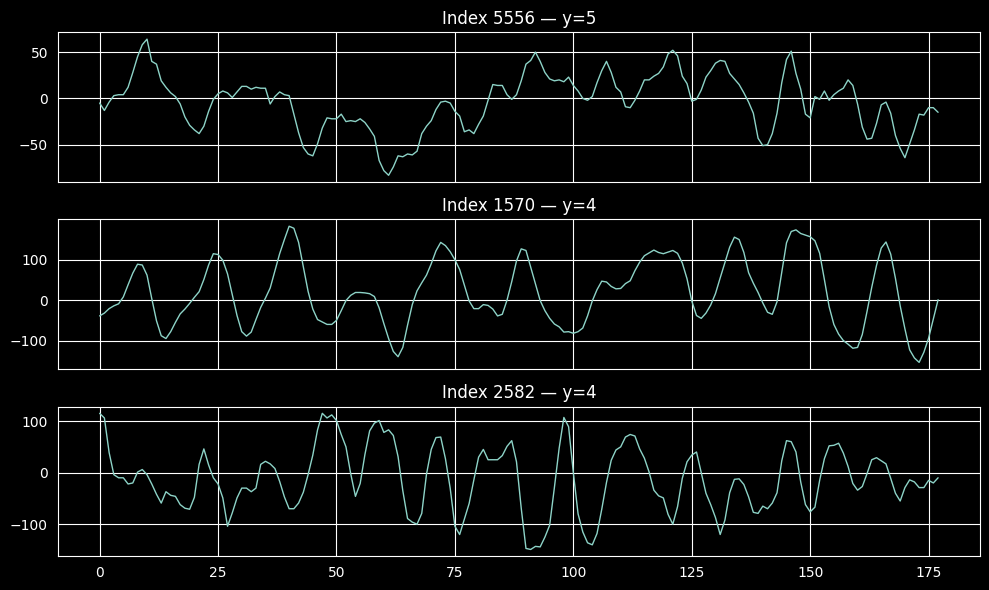

In [9]:
if df_eeg is not None:
    print("Missing values per column (top 10):")
    display(df_eeg.isna().sum().sort_values(ascending=False).head(10))
    display(df_eeg.describe().T.head(10))

    # Plot a few random samples
    sample_idxs = np.random.choice(df_eeg.index, size=min(3, len(df_eeg)), replace=False)
    fig, axes = plt.subplots(len(sample_idxs), 1, figsize=(10, 6), sharex=True)
    if len(sample_idxs) == 1:
        axes = [axes]
    for ax, idx in zip(axes, sample_idxs):
        row = df_eeg.loc[idx]
        # columns x1..x178 exist in the dataset
        signal = row.filter(regex=r'^X?\d+$|^x\d+$|^x_?\d+$|^\d+$', axis=0)
        if signal.empty:
            # fallback: assume columns 1..178 are features and 'y' target
            signal = row.drop(labels=['y'], errors='ignore')
        ax.plot(signal.values, lw=1)
        ax.set_title(f"Index {idx} — y={row.get('y', 'NA')}")
    plt.tight_layout()
    plt.show()


### Prepare data: binarize target, train/test split

Target column is `y` with values 1..5. We convert to binary: 1 vs not 1.


In [10]:
def prepare_eeg_xy(df: pd.DataFrame):
    # Detect target column
    target_col = 'y' if 'y' in df.columns else ('Y' if 'Y' in df.columns else None)
    assert target_col is not None, "Target column 'y' not found"

    y_multiclass = df[target_col].values
    y = (y_multiclass == 1).astype(int)

    # Feature columns: drop target, keep numeric
    X = df.drop(columns=[target_col])
    # Some versions have the first column as an id; drop if non-numeric or useless
    X = X.select_dtypes(include=[np.number])
    return X, y

if df_eeg is not None:
    X_raw, y = prepare_eeg_xy(df_eeg)
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_raw, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    print(X_train_raw.shape, X_test_raw.shape, np.mean(y_train), np.mean(y_test))


(9200, 178) (2300, 178) 0.2 0.2


### Baseline models on raw features

We train Logistic Regression and RandomForest using raw 178-dim signals.


In [11]:
def eval_clf(name, clf, X_tr, y_tr, X_te, y_te):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    if hasattr(clf, 'predict_proba'):
        y_proba = clf.predict_proba(X_te)[:, 1]
    else:
        # fallback using decision_function
        if hasattr(clf, 'decision_function'):
            scores = clf.decision_function(X_te)
            # min-max to [0,1]
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        else:
            y_proba = y_pred.astype(float)

    metrics = {
        'accuracy': accuracy_score(y_te, y_pred),
        'f1': f1_score(y_te, y_pred),
        'roc_auc': roc_auc_score(y_te, y_proba)
    }
    print(f"\n{name}:")
    print(metrics)
    print(classification_report(y_te, y_pred, digits=4))
    return metrics

baseline_results = {}
if df_eeg is not None:
    pipe_lr = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=200, random_state=RANDOM_STATE))
    ])
    baseline_results['LR_raw'] = eval_clf('LogReg raw', pipe_lr, X_train_raw, y_train, X_test_raw, y_test)
    rf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))
    ])
    baseline_results['RF_raw'] = eval_clf('RandomForest raw', rf, X_train_raw, y_train, X_test_raw, y_test)



LogReg raw:
{'accuracy': 0.8156521739130435, 'f1': 0.152, 'roc_auc': 0.4996597353497164}
              precision    recall  f1-score   support

           0     0.8133    0.9989    0.8966      1840
           1     0.9500    0.0826    0.1520       460

    accuracy                         0.8157      2300
   macro avg     0.8816    0.5408    0.5243      2300
weighted avg     0.8406    0.8157    0.7477      2300


RandomForest raw:
{'accuracy': 0.9782608695652174, 'f1': 0.945054945054945, 'roc_auc': 0.9966020793950852}
              precision    recall  f1-score   support

           0     0.9838    0.9891    0.9864      1840
           1     0.9556    0.9348    0.9451       460

    accuracy                         0.9783      2300
   macro avg     0.9697    0.9620    0.9658      2300
weighted avg     0.9781    0.9783    0.9782      2300



### Feature extraction: FFT

We compute magnitude spectrum features and simple band powers via Welch.


In [12]:
def compute_fft_features(X: pd.DataFrame, fs: float = 178.0):
    # X rows are signals length ~178
    X_np = X.to_numpy()
    n = X_np.shape[1]
    # Use rfft on each row
    mags = np.abs(np.fft.rfft(X_np, axis=1))
    # Basic stats of spectrum
    # Compute simple spectral stats; ensure 1D arrays for all features
    num = ((mags - mags.mean(axis=1, keepdims=True))**3).mean(axis=1)
    denom = (mags.std(axis=1)**3 + 1e-9)
    feats = {
        'spec_mean': mags.mean(axis=1),
        'spec_std': mags.std(axis=1),
        'spec_max': mags.max(axis=1),
        'spec_skew': num / denom,
    }

    # Welch band powers for a few arbitrary bands (Hz) assuming 178 samples/sec, 1 sec
    # Frequency resolution with 1 second is coarse; still compute relative band energies
    freqs, psd = welch(X_np, fs=fs, axis=1, nperseg=min(64, n))
    bands = [(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 60)]
    for (lo, hi) in bands:
        mask = (freqs >= lo) & (freqs < hi)
        band_power = psd[:, mask].sum(axis=1)
        feats[f'band_{lo}_{hi}'] = band_power

    return pd.DataFrame(feats, index=X.index)

if df_eeg is not None:
    X_train_fft = compute_fft_features(X_train_raw)
    X_test_fft = compute_fft_features(X_test_raw)

    pipe_lr_fft = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
    ])
    baseline_results['LR_fft'] = eval_clf('LogReg FFT', pipe_lr_fft, X_train_fft, y_train, X_test_fft, y_test)
    rf_fft = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
    ])
    baseline_results['RF_fft'] = eval_clf('RandomForest FFT', rf_fft, X_train_fft, y_train, X_test_fft, y_test)



LogReg FFT:
{'accuracy': 0.9543478260869566, 'f1': 0.8788927335640139, 'roc_auc': 0.9873026937618148}
              precision    recall  f1-score   support

           0     0.9583    0.9859    0.9719      1840
           1     0.9361    0.8283    0.8789       460

    accuracy                         0.9543      2300
   macro avg     0.9472    0.9071    0.9254      2300
weighted avg     0.9538    0.9543    0.9533      2300


RandomForest FFT:
{'accuracy': 0.981304347826087, 'f1': 0.9537136706135629, 'roc_auc': 0.9976913988657846}
              precision    recall  f1-score   support

           0     0.9907    0.9859    0.9883      1840
           1     0.9446    0.9630    0.9537       460

    accuracy                         0.9813      2300
   macro avg     0.9676    0.9745    0.9710      2300
weighted avg     0.9815    0.9813    0.9814      2300



### Feature extraction: Wavelet (PyWavelets)

We compute energies/statistics over DWT coefficients.


In [13]:
def compute_wavelet_features(X: pd.DataFrame, wavelet: str = 'db4', level: int = 3):
    X_np = X.to_numpy()
    rows, cols = X_np.shape
    feats = {}
    # per level stats
    stats = {}
    for i in range(rows):
        coeffs = pywt.wavedec(X_np[i, :], wavelet=wavelet, level=level)
        # coeffs[0] = cA (approximation), others are cD levels
        row_stats = {}
        for j, c in enumerate(coeffs):
            row_stats[f'L{j}_mean'] = np.mean(c)
            row_stats[f'L{j}_std'] = np.std(c)
            row_stats[f'L{j}_energy'] = np.sum(c**2)
            row_stats[f'L{j}_kurt'] = pd.Series(c).kurtosis()
        stats[i] = row_stats
    feats = pd.DataFrame.from_dict(stats, orient='index')
    feats.index = X.index
    return feats

if df_eeg is not None:
    X_train_wav = compute_wavelet_features(X_train_raw)
    X_test_wav = compute_wavelet_features(X_test_raw)

    pipe_lr_wav = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
    ])
    baseline_results['LR_wavelet'] = eval_clf('LogReg Wavelet', pipe_lr_wav, X_train_wav, y_train, X_test_wav, y_test)
    rf_wav = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1))
    ])
    baseline_results['RF_wavelet'] = eval_clf('RandomForest Wavelet', rf_wav, X_train_wav, y_train, X_test_wav, y_test)



LogReg Wavelet:
{'accuracy': 0.9608695652173913, 'f1': 0.898876404494382, 'roc_auc': 0.9934274574669186}
              precision    recall  f1-score   support

           0     0.9679    0.9837    0.9757      1840
           1     0.9302    0.8696    0.8989       460

    accuracy                         0.9609      2300
   macro avg     0.9491    0.9266    0.9373      2300
weighted avg     0.9604    0.9609    0.9604      2300


RandomForest Wavelet:
{'accuracy': 0.9843478260869565, 'f1': 0.9607843137254902, 'roc_auc': 0.9983264413988657}
              precision    recall  f1-score   support

           0     0.9897    0.9908    0.9902      1840
           1     0.9629    0.9587    0.9608       460

    accuracy                         0.9843      2300
   macro avg     0.9763    0.9747    0.9755      2300
weighted avg     0.9843    0.9843    0.9843      2300



### Auto feature extraction: tsfresh (optional)

tsfresh can compute many statistical features. It requires long-format input.


In [14]:
def compute_tsfresh_features(X: pd.DataFrame):
    try:
        from tsfresh import extract_features
    except Exception as e:
        print("tsfresh is not available, skipping. Error:", e)
        return None

    # Build long format: columns [id, time, value]
    long_df = []
    for i, (idx, row) in enumerate(X.iterrows()):
        vals = row.values
        long_df.append(pd.DataFrame({
            'id': i,
            'time': np.arange(len(vals)),
            'value': vals
        }))
    long_df = pd.concat(long_df, ignore_index=True)

    feats = extract_features(long_df, column_id='id', column_sort='time', column_value='value', disable_progressbar=True)
    # Keep the same index order as X
    feats.index = X.index
    # Remove constant columns
    nunique = feats.nunique()
    feats = feats.loc[:, nunique > 1]
    return feats

if df_eeg is not None:
    X_train_ts = compute_tsfresh_features(X_train_raw)
    X_test_ts = compute_tsfresh_features(X_test_raw) if X_train_ts is not None else None

    if X_train_ts is not None and X_test_ts is not None and not X_train_ts.empty:
        pipe_lr_ts = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=False)),  # features may be sparse-like
            ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ])
        baseline_results['LR_tsfresh'] = eval_clf('LogReg tsfresh', pipe_lr_ts, X_train_ts, y_train, X_test_ts, y_test)
        rf_ts = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('rf', RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1))
        ])
        baseline_results['RF_tsfresh'] = eval_clf('RandomForest tsfresh', rf_ts, X_train_ts, y_train, X_test_ts, y_test)
    else:
        print("Skipping tsfresh models due to missing features.")


tsfresh is not available, skipping. Error: Numba needs NumPy 2.3 or less. Got NumPy 2.4.
Skipping tsfresh models due to missing features.


### Summary of EEG approaches


In [15]:
if df_eeg is not None:
    print("\nEEG Results Summary:")
    for k, v in baseline_results.items():
        print(k, v)



EEG Results Summary:
LR_raw {'accuracy': 0.8156521739130435, 'f1': 0.152, 'roc_auc': 0.4996597353497164}
RF_raw {'accuracy': 0.9782608695652174, 'f1': 0.945054945054945, 'roc_auc': 0.9966020793950852}
LR_fft {'accuracy': 0.9543478260869566, 'f1': 0.8788927335640139, 'roc_auc': 0.9873026937618148}
RF_fft {'accuracy': 0.981304347826087, 'f1': 0.9537136706135629, 'roc_auc': 0.9976913988657846}
LR_wavelet {'accuracy': 0.9608695652173913, 'f1': 0.898876404494382, 'roc_auc': 0.9934274574669186}
RF_wavelet {'accuracy': 0.9843478260869565, 'f1': 0.9607843137254902, 'roc_auc': 0.9983264413988657}
